In [1]:
import sys
sys.executable
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from pandas import DataFrame
from pandas import read_csv
import math
from numpy import savetxt
from scipy.integrate import odeint, RK45
from tensorflow.keras.utils import plot_model
import timeit


## Mass-Spring-System
<img src="mass-spring-damper.png">


In [2]:
# Use ODEINT to solve the differential equations defined by the vector field
from scipy.integrate import odeint

def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x1, v1, x2, v2, x3, v3 = w
    m, k, kp, d, u1, u2, dist = p

    # Create f = (x1',y1',x2',y2'):
    f = [v1,
         (k * ((-2 * x1) + x2) + kp * (-x1 ** 3 + (x2 - x1) ** 3) + d * (v2-2*v1)) / m + u1,
         v2,
         (k * (x1 - (2 * x2) + x3) + kp * ((x3 - x2) ** 3 - (x2 - x1) ** 3) + d * (v1-2*v2+v3)) / m + u2,
         v3,
         (k * (x2 - x3) + kp * ((x2 - x3) ** 3) + d* (v2-v3)) / m + dist]
    return f

In [3]:
num_rollouts= 1
# Masses:
m = 0.5 
# Spring constants
kp = 63.5
k = 217.0
#damping constant
d= 0.15
# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6

num_data= 100003
interval= 0.001
stoptime = interval*(num_data)
np.random.seed(98)
hist= np.zeros((1,15))

for roll in range(1):
    act1= 2000*(np.random.rand(num_data)-0.5)
    act2= 2000*(np.random.rand(num_data)-0.5)
    dist = 1000*(np.random.rand(num_data)-0.5)
    #Initial states
    w0= np.zeros((1,6))
    #w0 = np.random.randn(1,6) 
    w0= w0.flatten()
    prev = [[w0[0],w0[2],w0[4]]]
    # Pack up the parameters and initial conditions:
    p = [m, k, kp, d, act1[0], act2[0], dist[0]]
    # Call the ODE solver.
    t1= np.array([0,interval])
    wsol1 = odeint(vectorfield, w0, t1, args=(p,),
            atol=abserr, rtol=relerr)
    wsol1 = wsol1.flatten()
    wcurr = np.array([wsol1[6:]])
    w0=wsol1[6:]
    prevv= prev
    prev = [[w0[0],w0[2],w0[4]]]
    # Pack up the parameters and initial conditions:
    p = [m, k, kp, d, act1[1], dist[1], act2[1]]
    # Call the ODE solver.
    t2= np.array([0+interval,interval+interval])
    wsol1 = odeint(vectorfield, w0, t2, args=(p,),
            atol=abserr, rtol=relerr)
    wsol1 = wsol1.flatten()
    wcurr = np.array([wsol1[6:]])
    w0=wsol1[6:]
    curr = np.hstack((prevv, prev, np.array([[act1[1]]]),np.array([[dist[1]]]),np.array([[act2[1]]]),wcurr))
    hist= np.vstack((hist, curr))
   
    lag=2
    for ts in range(num_data-lag):
        prevv = prev
        t = np.array([stoptime * float(ts+lag) / (num_data), stoptime * float(ts + lag + 1) / (num_data)])
        p = [m, k, kp, d, act1[ts+lag],  dist[ts+lag], act2[ts+lag]]
        # Call the ODE solver.
        wsol1 = odeint(vectorfield, w0, t, args=(p,),
            atol=abserr, rtol=relerr)
        wsol1 = wsol1.flatten()
        w0 = wsol1[6:]
        prev = np.array([[wsol1[0],wsol1[2],wsol1[4]]])
        action= [act1[ts+lag],act2[ts+lag]]
        new = np.hstack((prevv,prev,np.array([[act1[ts+lag]]]),np.array([[dist[ts+lag]]]),np.array([[act2[ts+lag]]]),np.array([w0])))
        hist = np.vstack((hist, new))
hist=pd.DataFrame(data=hist,columns =["prev11", "prev22","prev33","prev1","prev2","prev3","u1","dist.","u2","x1", "v1", "x2", "v2", "x3", "v3"])
df=hist[1:][{"u1","dist.","u2","prev11","prev22","prev33","prev1","prev2","prev3","x1", "v1", "x2", "v2", "x3", "v3"}]
df = df[['u1','dist.','u2',"prev11","prev22","prev33","prev1","prev2","prev3",'x1','v1','x2','v2','x3','v3']]
df

,u1,dist.,u2,prev11,prev22,prev33,prev1,prev2,prev3,x1,v1,x2,v2,x3,v3
1,134.378031,-202.781346,743.196551,0.000000,0.000000,0.000000,0.000232,0.000399,0.000171,0.000764,0.598682,0.001095,0.594543,0.000886,1.086082
2,-397.552220,216.548560,-653.882830,0.000232,0.000399,0.000171,0.000764,0.001095,0.000886,0.001164,0.200855,0.001798,0.810783,0.001645,0.432229
3,561.165851,-450.425189,-35.193601,0.000764,0.001095,0.000886,0.001164,0.001798,0.001645,0.001645,0.761654,0.002383,0.359823,0.002060,0.397205
4,-4.251444,-69.308320,-901.145093,0.001164,0.001798,0.001645,0.001645,0.002383,0.002060,0.002404,0.756394,0.002708,0.290110,0.002006,-0.503634
5,-762.179627,245.726838,671.250207,0.001645,0.002383,0.002060,0.002404,0.002708,0.002006,0.002779,-0.006935,0.003121,0.535102,0.001839,0.168236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99998,765.210611,396.117645,-190.032638,0.922970,1.754718,2.792237,0.926980,1.745021,2.734899,0.931395,4.752094,1.735714,-9.059313,2.676526,-58.723901
99999,-539.625558,383.386758,102.344989,0.926980,1.745021,2.734899,0.931395,1.735714,2.676526,0.935827,4.109189,1.726886,-8.602473,2.617611,-59.101635
100000,899.212938,161.106786,699.559098,0.931395,1.735714,2.676526,0.935827,1.726886,2.617611,0.940329,4.893099,1.718389,-8.396448,2.558634,-58.844959
100001,707.008908,-226.782215,-396.999056,0.935827,1.726886,2.617611,0.940329,1.718389,2.558634,0.945513,5.471794,1.709890,-8.604885,2.499385,-59.649208


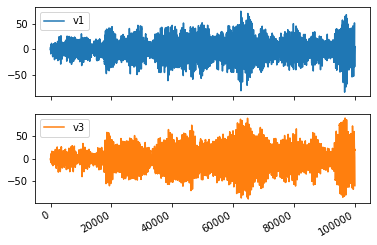

In [4]:
plot_cols = ['v1', 'v3']
plot_features = hist[plot_cols][:]
_ = plot_features.plot(subplots=True)

In [5]:
NN_in= df[{"u1","u2","dist."}]
NN_in= NN_in[['u1','dist.','u2']].shift(-1)
NN_label= df[{"x1", "x3"}]
NN_label= NN_label[ ["x1", "x3"] ]
NN_previous= df[{"prev11","prev33","prev1","prev3"}]
NN_previous= NN_previous[ ["prev11","prev33"] ]
diff1= df["x1"] - df["prev1"]
diff3= df["x3"] - df["prev3"]
diff21= df["x1"] - df["prev11"]
diff23= df["x3"] - df["prev33"]
df.insert(7, "diff21", diff21)
df.insert(8, "diff23", diff23)
df.insert(9, "diff1", diff1)
df.insert(10, "diff3", diff3)
bothdiff= df[["diff1","diff3"]].shift(0)
bothdiff2= df[["diff21","diff23"]].shift(0)
frames = [NN_in,bothdiff2, NN_label, NN_previous, bothdiff]
df = pd.concat(frames, axis=1)
#x1_ = df[{'x1'}]
#x3_ = df[{'x3'}]
#prev111 = x1_.shift(3)
#prev333 = x3_.shift(3)
#prev1111 = x1_.shift(4)
#prev3333 = x3_.shift(4)
#df.insert(3,"prev1111",prev1111)
#df.insert(4,"prev3333",prev3333)
#df.insert(3,"prev111",prev111)
#df.insert(4,"prev333",prev333)
#diff31= df["x1"] - df["prev111"]
#diff33= df["x3"] - df["prev333"]
#df=df.drop(columns=["prev111","prev333"])
#df.insert(3, "diff31", diff31)
#df.insert(4, "diff33", diff33)
af=df.dropna()
df= af[ ["u1","dist.","u2", "x1", "x3","diff21","diff23","diff1","diff3"] ]
df

,u1,dist.,u2,x1,x3,diff21,diff23,diff1,diff3
1,-397.552220,216.548560,-653.882830,0.000764,0.000886,0.000764,0.000886,0.000532,0.000714
2,561.165851,-450.425189,-35.193601,0.001164,0.001645,0.000931,0.001474,0.000400,0.000759
3,-4.251444,-69.308320,-901.145093,0.001645,0.002060,0.000881,0.001174,0.000481,0.000415
4,-762.179627,245.726838,671.250207,0.002404,0.002006,0.001240,0.000361,0.000759,-0.000053
5,-222.880954,-40.782215,269.076572,0.002779,0.001839,0.001134,-0.000221,0.000375,-0.000168
...,...,...,...,...,...,...,...,...,...
99997,765.210611,396.117645,-190.032638,0.926980,2.734899,0.007780,-0.114188,0.004010,-0.057338
99998,-539.625558,383.386758,102.344989,0.931395,2.676526,0.008426,-0.115711,0.004416,-0.058373
99999,899.212938,161.106786,699.559098,0.935827,2.617611,0.008847,-0.117288,0.004432,-0.058916
100000,707.008908,-226.782215,-396.999056,0.940329,2.558634,0.008934,-0.117892,0.004502,-0.058976


In [6]:
ww= df[0:5000]
ww.to_csv('u1000damptestdata5k_0.001ssim.csv',index=False)


In [7]:
ww

,u1,dist.,u2,x1,x3,diff21,diff23,diff1,diff3
1,-397.552220,216.548560,-653.882830,0.000764,0.000886,0.000764,0.000886,0.000532,0.000714
2,561.165851,-450.425189,-35.193601,0.001164,0.001645,0.000931,0.001474,0.000400,0.000759
3,-4.251444,-69.308320,-901.145093,0.001645,0.002060,0.000881,0.001174,0.000481,0.000415
4,-762.179627,245.726838,671.250207,0.002404,0.002006,0.001240,0.000361,0.000759,-0.000053
5,-222.880954,-40.782215,269.076572,0.002779,0.001839,0.001134,-0.000221,0.000375,-0.000168
...,...,...,...,...,...,...,...,...,...
4996,-128.591297,295.508591,792.944973,0.490894,0.724922,0.031978,-0.020041,0.015933,-0.009979
4997,-908.142628,-344.196625,498.391499,0.507004,0.715697,0.032043,-0.019204,0.016110,-0.009225
4998,647.717210,52.275070,-466.046005,0.522343,0.707021,0.031449,-0.017901,0.015339,-0.008676
4999,-786.284152,-34.898828,-547.928511,0.537288,0.698273,0.030285,-0.017424,0.014945,-0.008748


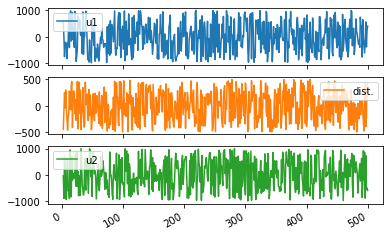

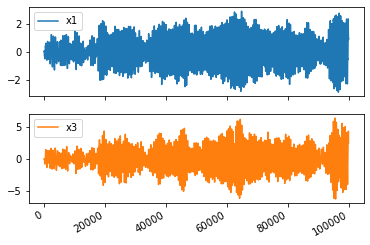

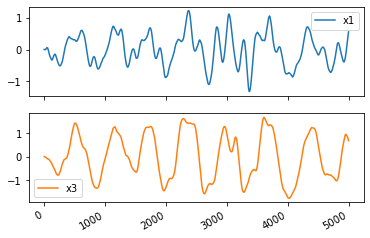

In [14]:
#max(df[{'diff1'}].values)
plot_cols = ['u1','dist.','u2']
plot_features = df[plot_cols][1:500]
_ = plot_features.plot(subplots=True)
plot_states = ['x1', 'v1', 'x2', 'v2', 'x3', 'v3']
plot_states = ['x1', 'x3']
plot_features = df[plot_states][:]
_ = plot_features.plot(subplots=True)
plot_out= ['x1','x3']
plot_features = df[plot_out][1:5000]
_ = plot_features.plot(subplots=True)

In [2]:
aaa= pd.read_csv('nodistreinf_startsim40000_train500-250_batch16sim300-1000-1000-pen10xcost.csv')
aaa

,u1,dist.,u2,x1,x3,diff21,diff23,diff1,diff3
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,229.013742,-0.264280,61.239602,0.000458,0.000122,0.000458,0.000122,0.000458,0.000122
2,500.000000,-0.967835,72.232584,0.002369,0.000511,0.002369,0.000511,0.001911,0.000389
3,182.693358,-0.838642,425.745459,0.005632,0.001894,0.005174,0.001772,0.003263,0.001383
4,78.116198,-0.517731,436.415194,0.009389,0.004996,0.007020,0.004485,0.003758,0.003102
...,...,...,...,...,...,...,...,...,...
40596,707.825893,-0.958254,-110.357970,1.000447,1.998983,0.003415,-0.005786,0.001667,-0.003775
40597,370.418452,1.000984,706.318781,1.002298,1.994632,0.003518,-0.008126,0.001851,-0.004351
40598,-146.209952,2.309658,1000.000000,1.002655,1.991996,0.002208,-0.006987,0.000357,-0.002636
40599,-178.609595,1.275693,1000.000000,1.000465,1.991731,-0.001832,-0.002901,-0.002190,-0.000265


<Figure size 576x216 with 0 Axes>

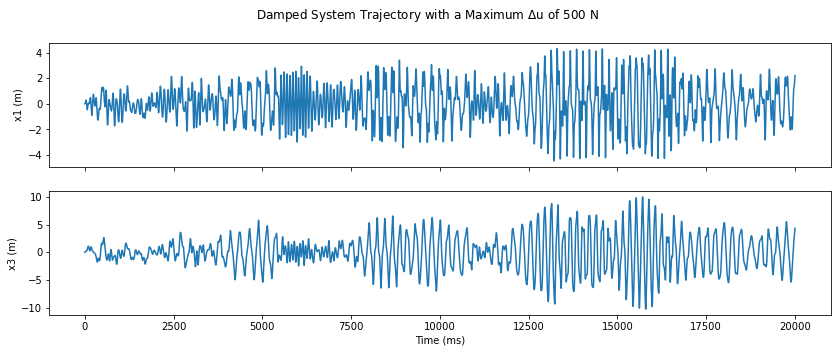

In [7]:
plt.figure(figsize=(8,3))
fig, axs = plt.subplots(2, sharex=True,figsize=(14,5))
x= range(20001)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
y=aaa.iloc[:20001,3].values
z=aaa.iloc[:20001,4].values
fig.suptitle('Damped System Trajectory with a Maximum $\Delta$u of 500 N')
axs[0].plot(x, y )
axs[1].plot(x, z)
axs[0].set_ylabel("x1 (m)") 
axs[1].set_ylabel("x3 (m)") 
axs[1].set_xlabel("Time (ms)") 
#axs[0].set_title("Position (m)") 
#axs[0].plot(range(5000), aaa.iloc[:,3].values, 'B')
plt.savefig('reinfdampuctr.png', dpi=300)

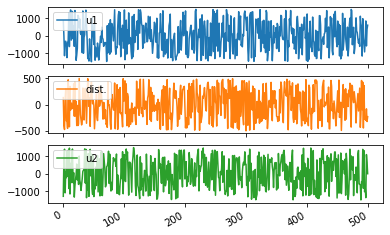

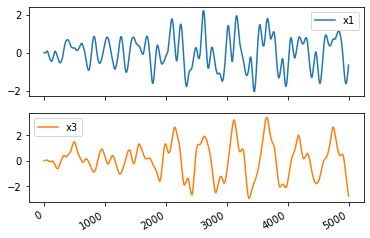

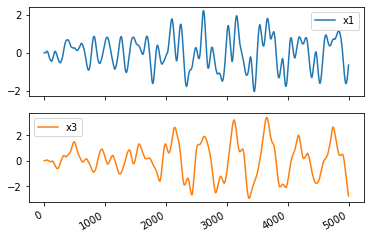

In [17]:
#max(df[{'diff1'}].values)
plot_cols = ['u1','dist.','u2']
plot_features = aaa[plot_cols][1:500]
_ = plot_features.plot(subplots=True)
plot_states = ['x1', 'v1', 'x2', 'v2', 'x3', 'v3']
plot_states = ['x1', 'x3']
plot_features = aaa[plot_states][:]
_ = plot_features.plot(subplots=True)
plot_out= ['x1','x3']
plot_features =aaa[plot_out][1:5000]
_ = plot_features.plot(subplots=True)

In [10]:
max(aaa.iloc[:,2])

999.9018642509444

In [11]:
df.mean()

u1        0.697769
dist.    -0.808389
u2       -1.358473
x1       -0.000869
x3       -0.004468
diff21    0.000019
diff23    0.000051
diff1     0.000009
diff3     0.000025
dtype: float64

In [12]:
df.std()

u1        577.886033
dist.     288.930849
u2        577.681133
x1          0.938599
x3          2.045237
diff21      0.036517
diff23      0.052864
diff1       0.018262
diff3       0.026434
dtype: float64